# Practica 2

## Instalación de dependencias

In [ ]:
!pip install -q timm datasets peft transformers torch torchvision

## Importaciones

In [ ]:
import torch
import torchvision.transforms as transforms
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from PIL import Image
import numpy as np

## Preparación del dataset

In [ ]:
dataset = load_dataset("flwrlabs/caltech101")

# Filtrar un subconjunto simple: motorbikes (label 50) vs no motorbikes
def filter_dataset(example):
    return example['label'] == 50 or example['label'] != 50  # 50 = motorbikes, otros = no motorbikes

dataset['train'] = dataset['train'].filter(filter_dataset)
dataset['train'] = dataset['train'].map(lambda x: {'label': 1 if x['label'] == 50 else 0})  # 1=motorbike, 0=no motorbike

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_images(examples):
    images = [transform(img.convert("RGB")) for img in examples['image']]
    pixel_values = torch.stack(images).float()  # Forzar a float32 explícitamente
    labels = torch.tensor(examples['label'], dtype=torch.long)  # Forzar a long
    return {'pixel_values': pixel_values, 'labels': labels}

dataset['train'] = dataset['train'].map(preprocess_images, batched=True, remove_columns=['image'])
dataset['train'].set_format('torch', columns=['pixel_values', 'labels'])  # Sin especificar dtype aquí

# Para experimentar: Sube tu ZIP con imágenes
# from google.colab import files
# uploaded = files.upload()
# !unzip -q tu_archivo.zip -d dataset
# import os
# from datasets import Dataset
# data = {'image': [], 'label': []}
# for label in os.listdir('dataset'):
#     for img in os.listdir(f'dataset/{label}'):
#         data['image'].append(Image.open(f'dataset/{label}/{img}').convert("RGB"))
#         data['label'].append(1 if label == 'motorbike' else 0)
# dataset = Dataset.from_dict(data).train_test_split(test_size=0.2)
# dataset['train'] = dataset['train'].map(preprocess_images, batched=True, remove_columns=['image'])

print("Ejemplo de datos:", dataset['train'][0])
print("Número de muestras en train:", len(dataset['train']))

Filter:   0%|          | 0/8677 [00:00<?, ? examples/s]

Map:   0%|          | 0/8677 [00:00<?, ? examples/s]

Map:   0%|          | 0/8677 [00:00<?, ? examples/s]

Ejemplo de datos: {'pixel_values': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.640

## Carga del modelo y tokenizer

In [ ]:
model_name = "google/vit-base-patch16-224-in21k"

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # 2 clases: motorbike vs no motorbike
    ignore_mismatched_sizes=True,
)

if hasattr(model.config, 'pad_token_id') and model.config.pad_token_id is None:
    model.config.pad_token_id = 0

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Congelar parámetros del modelo

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = False

## Verificar parámetros entrenables

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

print_trainable_parameters(model)

trainable params: 0 || all params: 85800194 || trainable%: 0.0


## Setup de Lora

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["classifier"],
    lora_dropout=0.1,
    bias="none",
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 6160 || all params: 85806354 || trainable%: 0.007178955535157688


## Setup del entrenamiento

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    warmup_steps=5,
    max_steps=20,
    learning_rate=2e-4,
    logging_steps=1,
    output_dir='outputs',
    report_to="none",
    save_steps=20,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == labels).mean()}

trainer = Trainer(
    model=model,
    train_dataset=dataset['train'],
    args=training_args,
    compute_metrics=compute_metrics,
)

## Entrenamiento

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.633000
2,0.604100
3,0.642900
4,0.638000
5,0.667400
6,0.714100
7,0.652000
8,0.686800
9,0.654000
10,0.673300


TrainOutput(global_step=20, training_loss=0.6545477896928787, metrics={'train_runtime': 57.065, 'train_samples_per_second': 1.402, 'train_steps_per_second': 0.35, 'total_flos': 6199804250357760.0, 'train_loss': 0.6545477896928787, 'epoch': 0.009216589861751152})

## Guardar el modelo con adaptadores

In [ ]:
model.save_pretrained("./adapter_model")
print("Modelo con adaptadores guardado en ./adapter_model")

Modelo con adaptadores guardado en ./adapter_model


## Inferencia simple

Predicción: no motorbike (confianza: 54.36%)


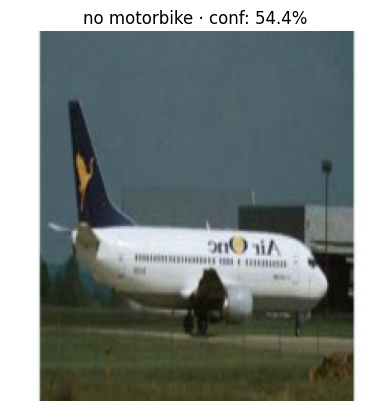

In [ ]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

sample = dataset["train"][0]
sample_image_tensor = sample["pixel_values"]

# Reconstruir imagen para visualizar (des-normalizar a RGB 0-255)
if sample_image_tensor.dim() == 3:  # [C,H,W]
    arr = sample_image_tensor.numpy()
elif sample_image_tensor.dim() == 4:  # [B,C,H,W]
    arr = sample_image_tensor[0].numpy()
else:
    raise ValueError(f"Forma inesperada: {sample_image_tensor.shape}")

# A [H,W,C]
arr = arr.transpose(1, 2, 0)
# Desnormalizar con stats ImageNet si tu dataset fue normalizado así:
arr = (arr * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
vis_img = (arr * 255).astype(np.uint8)

# --- Preprocesar para inferencia (normalizar) ---
img_array = np.array(vis_img, dtype=np.float32) / 255.0  # [H,W,C] en [0,1]
x = torch.from_numpy(img_array.transpose(2, 0, 1)).unsqueeze(0)  # [1,C,H,W]
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
x = (x - mean) / std
x = x.to(device)

# --- Inferencia ---
with torch.no_grad():
    outputs = model(x)
    logits = outputs.logits  # [1, num_classes]
    probs = torch.softmax(logits, dim=1)
    pred_idx = int(torch.argmax(probs, dim=1).item())
    pred_conf = float(probs[0, pred_idx].item())

idx2label = {0: "no motorbike", 1: "motorbike"}
pred_label = idx2label.get(pred_idx, str(pred_idx))

print(f"Predicción: {pred_label} (confianza: {pred_conf:.2%})")

# --- Mostrar imagen con título ---
plt.imshow(vis_img)
plt.axis("off")
plt.title(f"{pred_label} · conf: {pred_conf:.1%}")
plt.show()
